# Question 1. Sequence Tagging: NER

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade gensim

In [ ]:
import gensim.downloader
import os

os.chdir("..")

In [ ]:
w2v = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
print(len(w2v))

3000000


# Query the most similar vector


In [ ]:
words = ["student", "Apple", "apple"]

for w in words:
    most_sim_w, score = w2v.most_similar(positive= [w])[0]
    print(f"{w}:  {most_sim_w}, {score:.3f}")

student:  students, 0.729
Apple:  Apple_AAPL, 0.746
apple:  apples, 0.720


# Donwload dataset

In [ ]:
!pip install wget

In [ ]:
import wget

In [ ]:
# Question 1.2 Download

conll_raw_url = "https://raw.githubusercontent.com/TheAnig/NER-LSTM-CNN-Pytorch/master/data/"
filenames = ["eng.train", "eng.testa", "eng.testb"]

urls = {(f, f"{conll_raw_url}/{f}") for f in filenames}

for fn, url in urls:
    save_path = f"/content/drive/MyDrive/NLPdataset/{fn}"

    if os.path.exists(save_path):
        print(f"{fn} already exists. Skipping")
        continue
    wget.download(url, save_path)

eng.train already exists. Skipping
eng.testa already exists. Skipping
eng.testb already exists. Skipping


# Partition Dataset into training, development and test sets

In [ ]:
# File has one line

# First column is the word
# Second is POS tag
# Third is Consistuency parsing tag
# Fourth is NER tag

# The NER tagging column


root = '/content/drive/MyDrive/NLPdataset/'

# Returns a 3 dim array of sentences x words x (word_value, word_category)
def process_sets(filepath):
    raw = open(filepath)
    fin, curr = [], []
    tags = []

    for r in raw:
        if r == "\n":
            fin.append(curr)
            curr = []
            continue
        elif 'DOCSTART' in r:# Some files have these which are used to divide sentences
          continue
        else:
          r = r[:-1].split()

        if(len(r)!=4):
          print(r)
        curr.append([r[0],r[3]]) #Extract first and last column (NER Tag)
        if r[3] not in tags:
          tags.append(r[3])


    fin.append(curr)
    return fin,tags

trainset,traintags = process_sets(root+ "eng.train")
devset, devtags= process_sets(root +"eng.testa")   # aka validation set
testset, testtags = process_sets(root +"eng.testb")

print (f'trainset (No. sentences): {len(trainset)}')
print (f'developmentset (No. sentences): {len(devset)}')
print (f'testset (No. sentences): {len(testset)}')

print(f'tags in training set are {traintags}')
print(f'tags in development set are {devtags}')
print(f'tags in testing set are {testtags}')
print(f'complete set of tags: {set(traintags+devtags+testtags)}')

trainset (No. sentences): 14987
developmentset (No. sentences): 3466
testset (No. sentences): 3684
tags in training set are ['I-ORG', 'O', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG']
tags in development set are ['O', 'I-ORG', 'I-LOC', 'I-MISC', 'I-PER', 'B-MISC']
tags in testing set are ['O', 'I-LOC', 'I-PER', 'I-MISC', 'I-ORG', 'B-ORG', 'B-MISC', 'B-LOC']
complete set of tags: {'O', 'B-ORG', 'B-LOC', 'I-MISC', 'I-LOC', 'I-ORG', 'B-MISC', 'I-PER'}


# Example sentence

In [ ]:
def joinString(entity, joinentity):
    if(entity==""):
        return joinentity
    elif(joinentity[0]=="'"):
        return entity + joinentity

    else:
        return entity + " " + joinentity


def getSentence():
    for sentence in trainset:
        named_entities = []
        previous_word = ''
        counter = 0 #Number of entities with more than one word
        current_tag = None #B,I,O
        entity_tag = None #e.g. PER, LOC, MISC
        word_length = 0
        for i,word in enumerate(sentence):
            if word[1]=='O': #If this is not an entity
                current_tag=None
                if word_length>1:
                    counter+=1
                if previous_word!='':
                    named_entities.append(previous_word)
                previous_word=''
                word_length=0
            else:
                if current_tag is None: #If the current named entity succeeds a 'O' or is the first word of the sentence
                    current_tag,entity_tag = word[1].split('-')
                    previous_word=joinString(previous_word,word[0])
                    word_length=1

                else:
                    tmp_tag,tmp_type = word[1].split('-')
                    if tmp_tag == 'B' or tmp_type!=entity_tag: #Beginning of a new named entity
                        if word_length>1:
                            counter+=1
                        named_entities.append(previous_word)
                        previous_word=''
                        word_length=0
                        current_tag,entitiy_tag=word[1].split('-')
                    else: #Continuation of the previous entity
                        previous_word=joinString(previous_word,word[0])
                        current_tag=tmp_tag
                        word_length+=1

                    if i == len(sentence)-1 and previous_word!='':
                        if(word_length>1):
                            counter+=1
                        named_entities.append(previous_word)

        if counter>2:
            return named_entities,sentence




In [ ]:
entities, sentence_tags = getSentence()

sentenceString = ""
for word in sentence_tags:
    sentenceString=joinString(sentenceString,word[0])

print(entities)
print(sentenceString)
print(sentence_tags)


['Germany', "Welsh National Farmers' Union", 'NFU', 'John Lloyd Jones', 'BBC radio']
" What we have to be extremely careful of is how other countries are going to take Germany's lead , " Welsh National Farmers' Union ( NFU ) chairman John Lloyd Jones said on BBC radio .
[['"', 'O'], ['What', 'O'], ['we', 'O'], ['have', 'O'], ['to', 'O'], ['be', 'O'], ['extremely', 'O'], ['careful', 'O'], ['of', 'O'], ['is', 'O'], ['how', 'O'], ['other', 'O'], ['countries', 'O'], ['are', 'O'], ['going', 'O'], ['to', 'O'], ['take', 'O'], ['Germany', 'I-LOC'], ["'s", 'O'], ['lead', 'O'], [',', 'O'], ['"', 'O'], ['Welsh', 'I-ORG'], ['National', 'I-ORG'], ['Farmers', 'I-ORG'], ["'", 'I-ORG'], ['Union', 'I-ORG'], ['(', 'O'], ['NFU', 'I-ORG'], [')', 'O'], ['chairman', 'O'], ['John', 'I-PER'], ['Lloyd', 'I-PER'], ['Jones', 'I-PER'], ['said', 'O'], ['on', 'O'], ['BBC', 'I-ORG'], ['radio', 'I-ORG'], ['.', 'O']]


# Out of vocabulary word preprocessing


In [ ]:
# function to get all words not in the word2vec model
def get_words_not_in_model(set, w2v):
    abs_w2v = [] # array to store words that are not in the word2vec model
    abs_w2v_lower = [] # array to store words that are not in the word2vec model, but are in lower case
    for sentences in set:
        for word, type in sentences:
            if word not in w2v.key_to_index:
                #print(word)
                abs_w2v.append(word)
                if word.lower() not in w2v.key_to_index:
                    abs_w2v_lower.append(word.lower())
    return abs_w2v, abs_w2v_lower

In [ ]:

# function to remove words that are puncutation, numbers, or special characters
def remove_punc_num_special(s):
    clean_set = []
    for sentence in s:
        clean_sentence = []
        for word, tag in sentence:
            if any(c.isalpha() for c in word):
                clean_sentence.append([word, tag])
        clean_set.append(clean_sentence)
    return clean_set


In [ ]:
def word_stemming(s,w2v):
    ps = PorterStemmer()
    stemmed_sentences=[]
    for sentence in s:
        stemmed_sentence=[]
        for word, tag in sentence:
            if (word not in w2v.key_to_index and  ps.stem(word) in w2v.key_to_index):
                stemmed_sentence.append([ps.stem(word),tag])
            else:
                stemmed_sentence.append([word,tag])
        stemmed_sentences.append(stemmed_sentence)
    return stemmed_sentences

In [ ]:
def remove_stop_words(s): #Try subword embedding first
    stop_words=['of','a','and','to',"'s"]
    stopless_sentences=[]
    for sentence in s:
        stopless_sentence=[]
        for word,tag in sentence:
            if word not in stop_words:
                stopless_sentence.append([word,tag])

        stopless_sentences.append(stopless_sentence)
    return stopless_sentences



In [ ]:
def hyphen_seperation(s,w2v):
    seperated_sentences=[]
    for sentence in s:
        seperated_sentence=[]
        for word,tag in sentence:
            array_of_words = word.split('-')
            for individual_word in array_of_words:
                seperated_sentence.append([individual_word,tag])
        seperated_sentences.append(seperated_sentence)
    return seperated_sentences

In [ ]:
# check number of words not in word2vec model
fullset = trainset + devset + testset
abs_w2v, abs_w2v_lower = get_words_not_in_model(fullset, w2v)
print(len(abs_w2v), len(abs_w2v_lower))

83402 83322


# Dataset Loading

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import time
import os
import random
import numpy as np
import string


In [ ]:
# takes in a set of sentences in the form of a list of lists of tuples, and
# returns a list of list of words and tags
def separate_words_tags(set):
    sentences = []
    labels = []

    for sentence in set:
        current_sentence = []
        current_label = []
        for word, tag in sentence:
            current_sentence.append(word)
            current_label.append(tag)
        sentences.append(current_sentence)
        labels.append(current_label)
    return sentences, labels

# class to create a dataset for the NER task
class NERDataset(Dataset):
    def __init__(self, sentences, labels, word_to_ix, tag_to_ix):
        self.sentences = sentences
        self.labels = labels
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        label = self.labels[index]
        original_length = len(sentence)

        sentence = [self.word_to_ix.get(word, 3000000) for word in sentence] # 3000000 is the index for <UNK>
        label = [self.tag_to_ix[tag] for tag in label]

        return torch.tensor(sentence, dtype=torch.long), torch.tensor(label, dtype=torch.long), original_length


# function to pad the sequences in a batch
def pad_collate(batch):
    (xx, yy, lens) = zip(*batch)  # unzip the batch

    x_lens = [len(x) for x in xx]  # get lengths of sequences
    y_lens = [len(y) for y in yy]  # get lengths of labels

    max_x_len = max(x_lens)
    max_y_len = max(y_lens)

    xx_pad = torch.full((len(xx), max_x_len), 3000000, dtype=torch.long)  # create a matrix filled with 3000000
    yy_pad = torch.zeros(len(yy), max_y_len, dtype=torch.long)  # create a matrix of zeros with correct dimensions

    for i, (x, y) in enumerate(zip(xx, yy)):
        xx_pad[i, :x_lens[i]] = x
        yy_pad[i, :y_lens[i]] = y

    return xx_pad, yy_pad, lens


In [ ]:
# clean dataset by removing meaningless words
import nltk
from nltk.stem import PorterStemmer

fullset = remove_punc_num_special(fullset) #Remove punctuation, special characters and numbers
fullset = hyphen_seperation(fullset,w2v) #Address hyphen separated words
fullset = word_stemming(fullset,w2v) #Porter Stemmer
fullset = remove_stop_words(fullset) #Remove stop words
abs_w2v, abs_w2v_lower = get_words_not_in_model(fullset, w2v)
print(len(abs_w2v), len(abs_w2v_lower))

#Trainset Transformation
trainset = remove_punc_num_special(trainset) #Remove punctuation, special characters and numbers
trainset = hyphen_seperation(trainset,w2v) #Address hyphen separated words
trainset = word_stemming(trainset,w2v) #Porter Stemmer
trainset = remove_stop_words(trainset) #Remove stop words
abs_w2v, abs_w2v_lower = get_words_not_in_model(trainset, w2v)
print(len(abs_w2v), len(abs_w2v_lower))

#Validation set transformation
devset = remove_punc_num_special(devset) #Remove punctuation, special characters and numbers
devset = hyphen_seperation(devset,w2v) #Address hyphen separated words
devset = word_stemming(devset,w2v) #Porter Stemmer
devset = remove_stop_words(devset) #Remove stop words
abs_w2v, abs_w2v_lower = get_words_not_in_model(devset, w2v)
print(len(abs_w2v), len(abs_w2v_lower))

#Test set transformation
testset = remove_punc_num_special(testset) #Remove punctuation, special characters and numbers
testset = hyphen_seperation(testset,w2v) #Address hyphen separated words
testset = word_stemming(testset,w2v) #Porter Stemmer
testset = remove_stop_words(testset) #Remove stop words
abs_w2v, abs_w2v_lower = get_words_not_in_model(testset, w2v)
print(len(abs_w2v), len(abs_w2v_lower))


3698 3672
2529 2513
604 599
565 560


# Map all words to embeddings

In [ ]:
w2v_size = len(w2v)
print(w2v_size)

3000000


In [ ]:
w2v_size = len(w2v)

w2v['<UNK>']=np.zeros(300)



word_to_ix = {"<PAD>":w2v_size,"<UNK>":w2v_size}
tag_to_ix = {"<PAD>": 0, "O": 1, "B-MISC": 2, "B-LOC": 3, "I-MISC": 4, "I-LOC": 5, "B-ORG": 6, "I-PER": 7, "I-ORG": 8}

#Map each word to a metric embedding
for sentence in fullset:
    for word,tag in sentence:
        if word in w2v.key_to_index:
            word_to_ix[word]=w2v.key_to_index[word]
        elif word.lower() in w2v.key_to_index:
            word_to_ix[word]=w2v.key_to_index[word.lower()]
        else:
            word_to_ix[word]=w2v.key_to_index['<UNK>']


In [ ]:
sentences, labels = separate_words_tags(trainset) # separate words and tags
train_data = NERDataset(sentences, labels, word_to_ix, tag_to_ix)

sentences, labels = separate_words_tags(devset)
dev_data = NERDataset(sentences, labels, word_to_ix, tag_to_ix)

sentences, labels = separate_words_tags(testset)
test_data = NERDataset(sentences, labels, word_to_ix, tag_to_ix)

# Creating DataLoader ; pad_collate function pads sentences to the length of the longest sentence in the batch
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)


# Long Short Term Memory

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import time
import os
import random
import numpy as np
import string



In [ ]:
!pip install seqeval

In [ ]:





# early stopping obtained from tutorial
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience # how many epochs to wait before stopping when loss is no longer decreasing
        self.min_delta = min_delta # minimum difference between new loss and old loss to be considered as a decrease in loss
        self.counter = 0 # number of epochs since loss was last decreased
        self.min_validation_loss = np.inf # minimum validation loss achieved so far

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss: # new loss is lower than old loss
            self.min_validation_loss = validation_loss # update minimum loss
            self.counter = 0 # reset counter
        elif validation_loss > (self.min_validation_loss + self.min_delta): # new loss is higher than old loss + minimum difference
            self.counter += 1 # increase counter
            if self.counter >= self.patience:
                return True # stop training
        return False # continue training


# set random seed
def set_seed(seed = 0):
    '''
    set random seed
    '''
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


# Train step
def train_step(model, trainloader, optimizer, device, lossfn):
    model.train()  # set model to training mode
    total_loss = 0.0

    # Iterate over the training data
    for i, data in trainloader:
        inputs, labels, _ = data  # get the inputs and labels
        inputs, labels = inputs.to(device), labels.to(device)  # move them to the device

        optimizer.zero_grad()  # zero the gradients

        # Forward pass
        outputs = model(inputs)
        loss = lossfn(outputs, labels)

        # Backward pass and optimisation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # accumulate the loss
        trainloader.set_postfix({'Training loss': '{:.4f}'.format(total_loss/(i+1))})  # Update the progress bar with the training loss

    train_loss = total_loss / len(trainloader)
    return train_loss



# Test step
def val_step(model, valloader, lossfn, device):
    from seqeval.metrics import f1_score
    idx_to_tag = {1:"O",2: "B-MISC",3: "B-LOC",4: "I-MISC",5: "I-LOC",6: "B-ORG",7: "I-PER",8: "I-ORG"}
    model.eval() # set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total_words = 0
    all_batch_preds = []  # List to store batch predictions
    all_batch_labels = []  # List to store batch labels

    with torch.no_grad(): # disable gradient calculation
        for data in valloader:
            inputs, labels, lens = data # get the inputs and labels and actual lengths
            inputs, labels = inputs.to(device), labels.to(device) # move them to the device

            # Forward pass
            outputs = model(inputs)
            loss = lossfn(outputs, labels)

            total_loss += loss.item()

            # Get the index of the max log-probability along the tagset_size dimension
            _, predicted = torch.max(outputs.permute(0, 2, 1), 2)

            batch_preds = []
            batch_labels = []

            batch_preds_acc = []
            batch_labels_acc = []

            for i in range(len(lens)):
                batch_preds.append([idx_to_tag[int(word)] for word in predicted[i, :lens[i]]])  # Append predictions but only up to the actual length of the sentence
                batch_labels.append([idx_to_tag[int(word)] for word in labels[i, :lens[i]]])

                batch_preds_acc.extend(predicted[i, :lens[i]].cpu().numpy())  # Append predictions but only up to the actual length of the sentence
                batch_labels_acc.extend(labels[i, :lens[i]].cpu().numpy())

            correct += sum(p == l for p, l in zip(batch_preds_acc, batch_labels_acc))  # Accumulate correct predictions for this batch
            total_words += sum(lens)  # Accumulate the actual sentence lengths for this batch

            all_batch_preds.extend(batch_preds)  # Append batch predictions to the list
            all_batch_labels.extend(batch_labels)  # Append batch labels to the list

    val_loss = total_loss / len(valloader)
    accuracy = 100 * correct / total_words
    f1 = f1_score(all_batch_labels, all_batch_preds,average='macro')

    return val_loss, accuracy, f1




# Save model
def save_model(model, path):
    torch.save(model.state_dict(), path)


# Training loop
def train(model, tl, vl, opt, loss, device, epochs, early_stopper, path):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    f1_list = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        start_time = time.time()  # Record the start time of the epoch

        # Wrap the trainloader with tqdm for the progress bar
        pbar = tqdm(enumerate(tl), total=len(tl), desc=f"Epoch {epoch+1}/{epochs}")

        train_loss = train_step(model, pbar, opt, device, loss)  # Pass the tqdm-wrapped loader
        val_loss,val_acc, F1 = val_step(model, vl, loss, device)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        f1_list.append(F1)

        # Print time taken for epoch
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Epoch {epoch+1}/{epochs} took {elapsed_time:.2f}s | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.2f}% | F1: {F1:.4f} | EarlyStopper count: {early_stopper.counter}')

        # save as last_model after every epoch
        save_model(model, os.path.join(path, 'last_model.pt'))

        # save as best_model if validation loss is lower than previous best validation loss
        if val_loss < early_stopper.min_validation_loss:
            save_model(model, os.path.join(path, 'best_model.pt'))

        if early_stopper.early_stop(val_loss):
            print('Early stopping')
            break

    return train_loss_list, val_loss_list, val_acc_list, f1_list




# word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(w2v.vectors), freeze=False)
# word_embeddings(torch.LongTensor([w2v.key_to_index['<UNK>']]))

# Defining Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# LSTM Model
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, weights_matrix=None, freeze_weights=True):
        super(NERModel, self).__init__()

        self.hidden_dim = hidden_dim

        if weights_matrix is not None:
            self.word_embeddings = nn.Embedding.from_pretrained(weights_matrix, freeze=freeze_weights)
            # initialize word embeddings with pretrained weights and freeze them
        else:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True,bidirectional=True)

        self.dropout = nn.Dropout(0.5)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # Linear layer maps from hidden state space to tag space


    def forward(self, sentences):
        '''
        sentences: batch_size x max_seq_length
        tag_space: batch_size x tagset_size x max_seq_length
        '''
        embeds = self.word_embeddings(sentences) # Embed the input sentence

        # LSTM input shape: batch_size x max_seq_length x embedding_dim
        lstm_out, _ = self.lstm(embeds)

        # LSTM output shape: batch_size x max_seq_length x hidden_dim
        # reshape it for the linear layer
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        # shape: (batch_size * max_seq_length) x hidden_dim

        lstm_out=self.dropout(lstm_out)

        tag_space = self.hidden2tag(lstm_out)

        # reshape back to batch_size x max_seq_length x tagset_size
        tag_space = tag_space.contiguous().view(sentences.shape[0], sentences.shape[1], -1)

        # swap dimensions to make it batch_size x tagset_size x max_seq_length
        tag_space = tag_space.permute(0, 2, 1)

        return tag_space # Return output

# Training

In [ ]:
embedding_dim = 300
hidden_dim = 1024
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
weights_matrix = torch.FloatTensor(w2v.vectors)


model = NERModel(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, tagset_size=tagset_size, weights_matrix=weights_matrix)

In [ ]:
lr = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss(ignore_index=0 )


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

epochs = 5 # number of epochs
early_stopper = EarlyStopper(patience=2) # initialise early stopper

# Make directory to save baseline model
model_path = "../saved_models/"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

In [ ]:
train_loss_list, val_loss_list, val_acc_list, f1_list = train(model, train_loader, dev_loader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/5: 100%|██████████| 937/937 [00:10<00:00, 88.04it/s, Training loss=0.2480]


Epoch 1/5 took 13.13s | Train loss: 0.2480 | Val loss: 0.1391 | Val accuracy: 95.52% | F1: 0.7267 | EarlyStopper count: 0


Epoch 2/5: 100%|██████████| 937/937 [00:10<00:00, 88.33it/s, Training loss=0.1304]


Epoch 2/5 took 12.99s | Train loss: 0.1304 | Val loss: 0.1237 | Val accuracy: 96.14% | F1: 0.7661 | EarlyStopper count: 0


Epoch 3/5: 100%|██████████| 937/937 [00:10<00:00, 89.40it/s, Training loss=0.1087]


Epoch 3/5 took 12.83s | Train loss: 0.1087 | Val loss: 0.1222 | Val accuracy: 96.23% | F1: 0.7726 | EarlyStopper count: 0


Epoch 4/5: 100%|██████████| 937/937 [00:10<00:00, 88.87it/s, Training loss=0.0903]


Epoch 4/5 took 12.98s | Train loss: 0.0903 | Val loss: 0.1100 | Val accuracy: 96.61% | F1: 0.7968 | EarlyStopper count: 0


Epoch 5/5: 100%|██████████| 937/937 [00:10<00:00, 88.35it/s, Training loss=0.0784]


Epoch 5/5 took 12.98s | Train loss: 0.0784 | Val loss: 0.1089 | Val accuracy: 96.68% | F1: 0.7939 | EarlyStopper count: 0


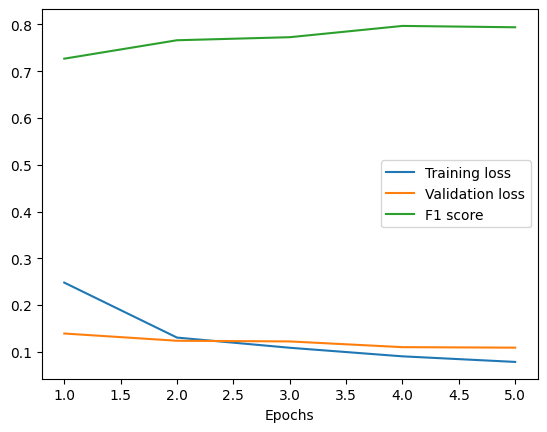

In [ ]:
import matplotlib.pyplot as plt

epoch_range = [i for i in range(1,epochs+1)]
# plot training and validation loss, and f1 score
plt.plot(epoch_range,train_loss_list, label='Training loss')
plt.plot(epoch_range,val_loss_list, label='Validation loss')
plt.plot(epoch_range,f1_list, label='F1 score')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# Test step


from seqeval.metrics import f1_score
idx_to_tag = {
1:"O",
2: "B-MISC",
3: "B-LOC",
4: "I-MISC",
5: "I-LOC",
6: "B-ORG",
7: "I-PER",
8: "I-ORG"
}
model.eval() # set model to evaluation mode
correct = 0
total_words = 0
all_batch_preds = []  # List to store batch predictions
all_batch_labels = []  # List to store batch labels

with torch.no_grad(): # disable gradient calculation
    for data in test_loader:
        inputs, labels, lens = data # get the inputs and labels and actual lengths
        inputs, labels = inputs.to(device), labels.to(device) # move them to the device

        # Forward pass
        outputs = model(inputs)

        # Get the index of the max log-probability along the tagset_size dimension
        _, predicted = torch.max(outputs.permute(0, 2, 1), 2)

        batch_preds = []
        batch_labels = []

        batch_preds_acc = []
        batch_labels_acc = []

        for i in range(len(lens)):
            batch_preds.append([idx_to_tag[int(word)] for word in predicted[i, :lens[i]]])  # Append predictions but only up to the actual length of the sentence
            batch_labels.append([idx_to_tag[int(word)] for word in labels[i, :lens[i]]])

            batch_preds_acc.extend(predicted[i, :lens[i]].cpu().numpy())  # Append predictions but only up to the actual length of the sentence
            batch_labels_acc.extend(labels[i, :lens[i]].cpu().numpy())



        correct += sum(p == l for p, l in zip(batch_preds_acc, batch_labels_acc))  # Accumulate correct predictions for this batch
        total_words += sum(lens)  # Accumulate the actual sentence lengths for this batch

        all_batch_preds.extend(batch_preds)  # Append batch predictions to the list
        all_batch_labels.extend(batch_labels)  # Append batch labels to the list

accuracy = 100 * correct / total_words
f1 = f1_score(all_batch_labels, all_batch_preds,average='macro')




In [ ]:
print(f'Accuracy: {accuracy: .2f}%, F1 Score: {f1: .2f}')

Accuracy:  94.36%, F1 Score:  0.73
